In [ ]:
import numpy as np
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import pandas as pd
import matplotlib.pyplot as plt
import joblib # for saving and loading variables
import os
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import f1_score
from pathlib import Path
import seaborn as sns

In [ ]:
# load the data (samples only)

file_folder = Path('C:/Users/ilkele4s/SVM_electrodes')

print(file_folder)

In [3]:
#cur_el = joblib.load('it.sav')
cur_el = 3

In [4]:
File = 'electrode_' +str(cur_el) + '.csv'
file_path = os.path.join(file_folder,File)
print(file_path)

C:\Users\ilkele4s\SVM_electrodes\electrode_3.csv


In [5]:
Data = pd.read_csv(file_path, header = None)

In [6]:
NewDirectory = 'Random_electrode_' +str(cur_el) 
os.mkdir(os.path.join(file_folder,NewDirectory))
NewDirectory = os.path.join(file_folder,NewDirectory)

In [7]:
NewDirectory = os.path.join(file_folder,NewDirectory)

In [8]:
np.shape(Data)

(1440, 300)

In [9]:
data_shape = np.shape(Data)

In [10]:
n_features = data_shape[1] # edit as data_array.shape[1]
print(n_features)

300


In [11]:
# create a label set

n_zones = 45
n_trials = 32

label_set = np.r_[1:n_zones+1]
labels = np.tile(label_set, 32)


In [12]:
np.shape(labels)

(1440,)

In [13]:
# merge samples and labels

Data[n_features] = labels

In [14]:
# remove NAN values

Data.dropna(inplace=True)
Data = Data.reset_index()
del Data['index']

In [15]:
np.shape(Data)

(895, 301)

In [16]:
data_shape2 = np.shape(Data)
n_samples = data_shape2[0]
print(n_samples)

895


In [17]:
# train - test split

all_ind = np.random.choice(np.arange(0, n_samples, 1), n_samples)
test_ind = all_ind[:int(n_samples/5)]
train_ind = all_ind[int(n_samples/5):]

test = Data.iloc[test_ind]
train = Data.iloc[train_ind]

In [18]:
# train - test split remove teh index column

test = test.reset_index()
del test['index']

train = train.reset_index()
del train['index']

In [19]:
# separate samples from labels

sample_ind = np.array(list(range(0,n_features)))
label_ind = n_features

train_samples = train[sample_ind]
train_labels = train[label_ind]

test_samples = test[sample_ind]
test_labels = test[label_ind]

# turning into arrays for skitlearn

train_samples_array = np.array(train_samples)
train_labels_array = np.array(train_labels)

test_samples_array = np.array(test_samples)
test_labels_array = np.array(test_labels)

# SHUFFLE
np.random.shuffle(train_labels_array)
np.random.shuffle(test_labels_array)


In [20]:
joblib.dump(train_samples_array, os.path.join(NewDirectory,'train_samples.sav'))
joblib.dump(train_labels_array, os.path.join(NewDirectory,'train_labels.sav'))

joblib.dump(test_samples_array, os.path.join(NewDirectory,'test_samples.sav'))
joblib.dump(test_labels_array, os.path.join(NewDirectory,'test_labels.sav'))

['C:\\Users\\ilkele4s\\SVM_electrodes\\Random_electrode_3\\test_labels.sav']

In [21]:
# model training with default parameters

svm_model_base = svm.SVC()
svm_model_base.fit(train_samples_array,train_labels_array)

SVC()

In [22]:
# predictions with

prediction_base = svm_model_base.predict(test_samples_array)

In [23]:
joblib.dump(prediction_base, os.path.join(NewDirectory,'base_prediction.sav'))

['C:\\Users\\ilkele4s\\SVM_electrodes\\Random_electrode_3\\base_prediction.sav']

In [24]:
# creating grid

param_grid = [{'class_weight': [None, 'balanced'], 'C':[0.5, 1, 10, 100], 'gamma': ['scale', 1, 0.1, 0.01, 0.001, 0.0001],'kernel': ['linear','rbf'], 'decision_function_shape': ['ovo','ovr']}]

In [25]:
# grid search

optimal_params = GridSearchCV(svm.SVC(), param_grid, cv=3, scoring='accuracy', verbose=0)

optimization = optimal_params.fit(train_samples_array, train_labels_array)


In [26]:
print(optimal_params.best_params_)

{'C': 10, 'class_weight': None, 'decision_function_shape': 'ovo', 'gamma': 0.01, 'kernel': 'rbf'}


In [27]:
joblib.dump(optimal_params.best_params_, os.path.join(NewDirectory,'best_params.sav'))

['C:\\Users\\ilkele4s\\SVM_electrodes\\Random_electrode_3\\best_params.sav']

In [28]:
dict_string = "\n".join([f"{key}: {value}" for key, value in optimal_params.best_params_.items()])

In [29]:
file = open(os.path.join(NewDirectory,'best_params.txt'), 'w')
# Write content to the file
file.write(dict_string)

77

In [30]:
# getting optimal values for the parameters

C_ = optimal_params.best_params_.get('C')
dfs_ = optimal_params.best_params_.get('decision_function_shape')
gamma_ = optimal_params.best_params_.get('gamma')
kernel_ = optimal_params.best_params_.get('kernel')
weight_ = optimal_params.best_params_.get('class_weight')

In [31]:
svm_model_optimized = svm.SVC(C=C_, class_weight=weight_, decision_function_shape=dfs_, gamma=gamma_, kernel=kernel_)
svm_model_optimized.fit(train_samples_array,train_labels_array)

SVC(C=10, decision_function_shape='ovo', gamma=0.01)

In [32]:
prediction_optimized = svm_model_optimized.predict(test_samples_array)

In [33]:
joblib.dump(prediction_optimized, os.path.join(NewDirectory,'optimized_prediction.sav'))

['C:\\Users\\ilkele4s\\SVM_electrodes\\Random_electrode_3\\optimized_prediction.sav']

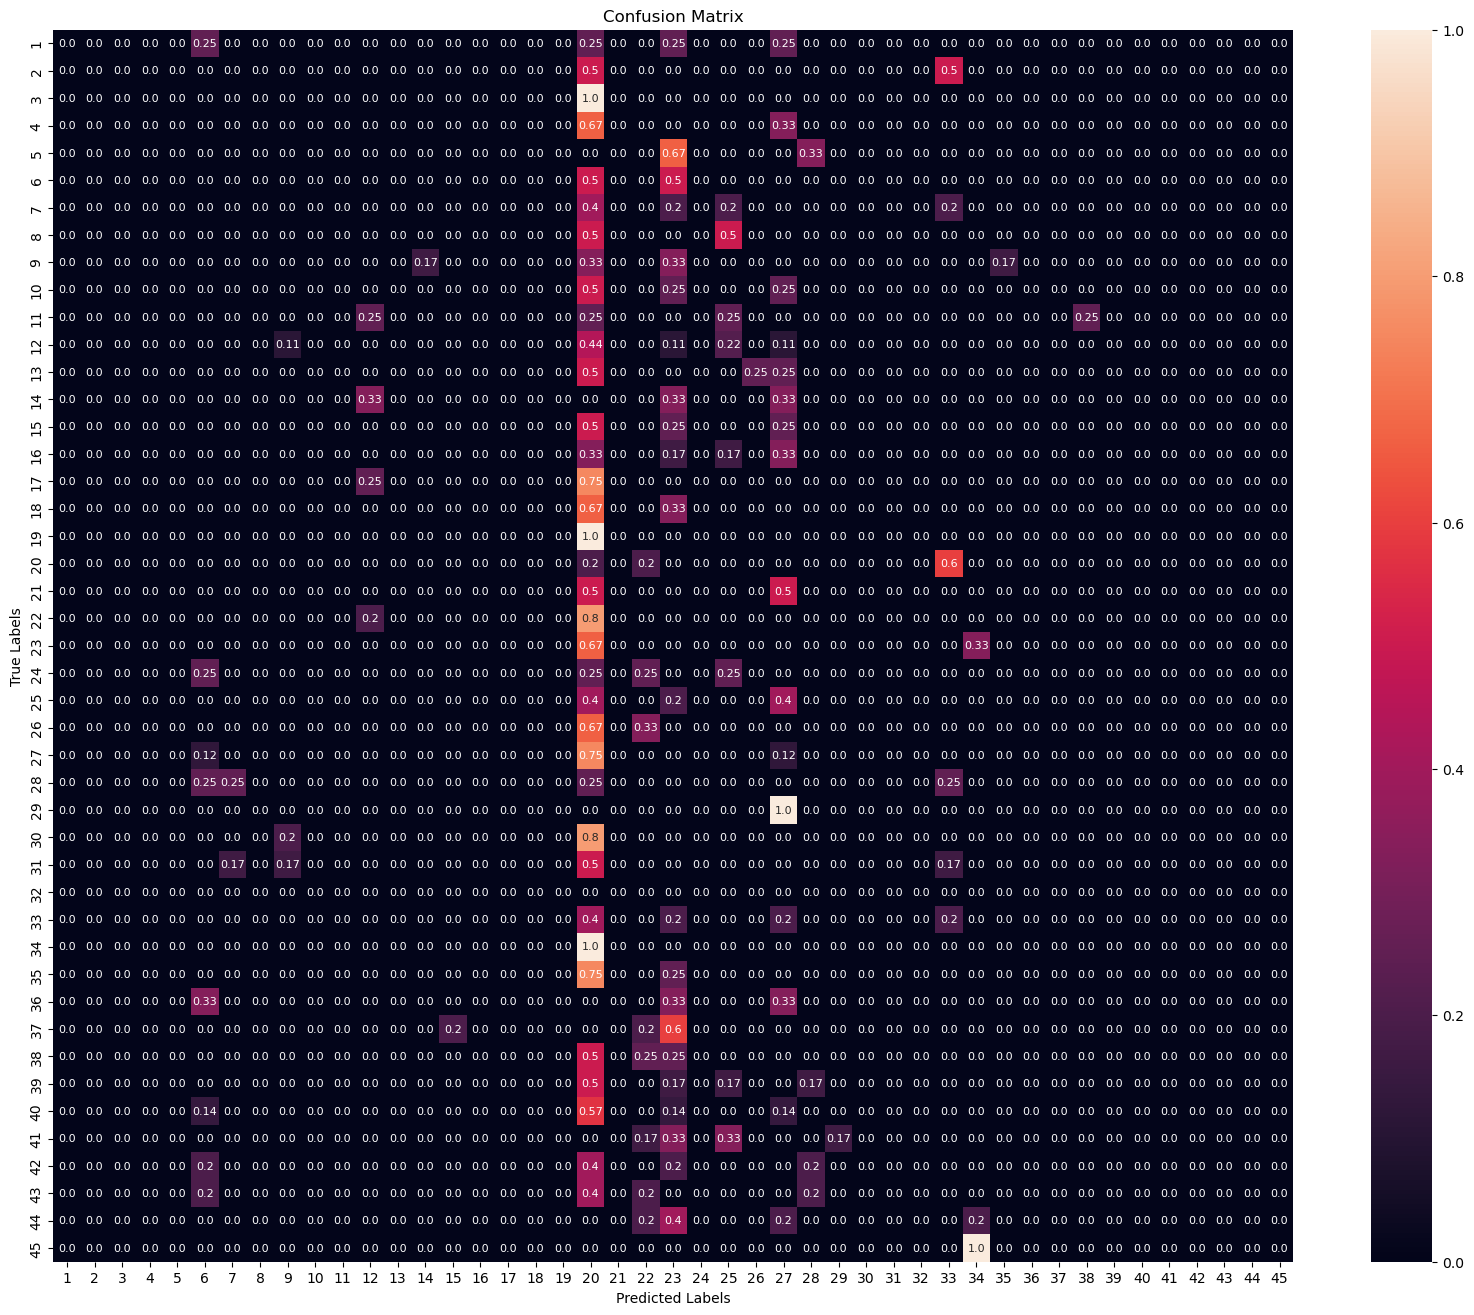

In [34]:

#%%
cm = confusion_matrix(test_labels_array, prediction_base, normalize='true', labels=svm_model_base.classes_)

plt.figure(figsize=(20, 16))
sns.heatmap(cm, fmt='.2', annot=True,annot_kws={"size": 8}, xticklabels=svm_model_base.classes_, yticklabels=svm_model_base.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.savefig(os.path.join(NewDirectory,'Cm_base.png'))
plt.show()



In [35]:
# confusion matrix for the base model

#cm = confusion_matrix(test_labels_array, prediction_base,  normalize='true', labels=svm_model_base.classes_)
#cmp = ConfusionMatrixDisplay(cm, display_labels=svm_model_base.classes_)
#fig, ax = plt.subplots(figsize=(40,40))

# Deactivate default colorbar
#cmp.plot(ax=ax, colorbar=False)

# Adding custom colorbar
#cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
#plt.colorbar(cmp.im_, cax=cax)

#plt.savefig(os.path.join(NewDirectory,'Cm_base.png'))

In [36]:
Acc_base= sum(test_labels_array == prediction_base)/len(test_labels_array)*100
print(Acc_base)

1.675977653631285


In [37]:
file = open( os.path.join(NewDirectory,'Acc_base.txt'), 'w')
# Write content to the file
file.write(str(Acc_base))

17

In [38]:
Acc_base2 = balanced_accuracy_score(test_labels_array, prediction_base)
print(Acc_base2)

0.011931818181818182


In [39]:
file = open( os.path.join(NewDirectory,'Acc_base2.txt'), 'w')
# Write content to the file
file.write(str(Acc_base2))

20

In [40]:
# confusion matrix for the optimized model

#cm = confusion_matrix(test_labels_array, prediction_optimized,  normalize='true', labels=svm_model_optimized.classes_)
#cmp = ConfusionMatrixDisplay(cm, display_labels=svm_model_base.classes_)
#fig, ax = plt.subplots(figsize=(40,40))

# Deactivate default colorbar
#cmp.plot(ax=ax, colorbar=False)

# Adding custom colorbar
#cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
#plt.colorbar(cmp.im_, cax=cax)
#plt.savefig(os.path.join(NewDirectory,'Cm_optim.png'))


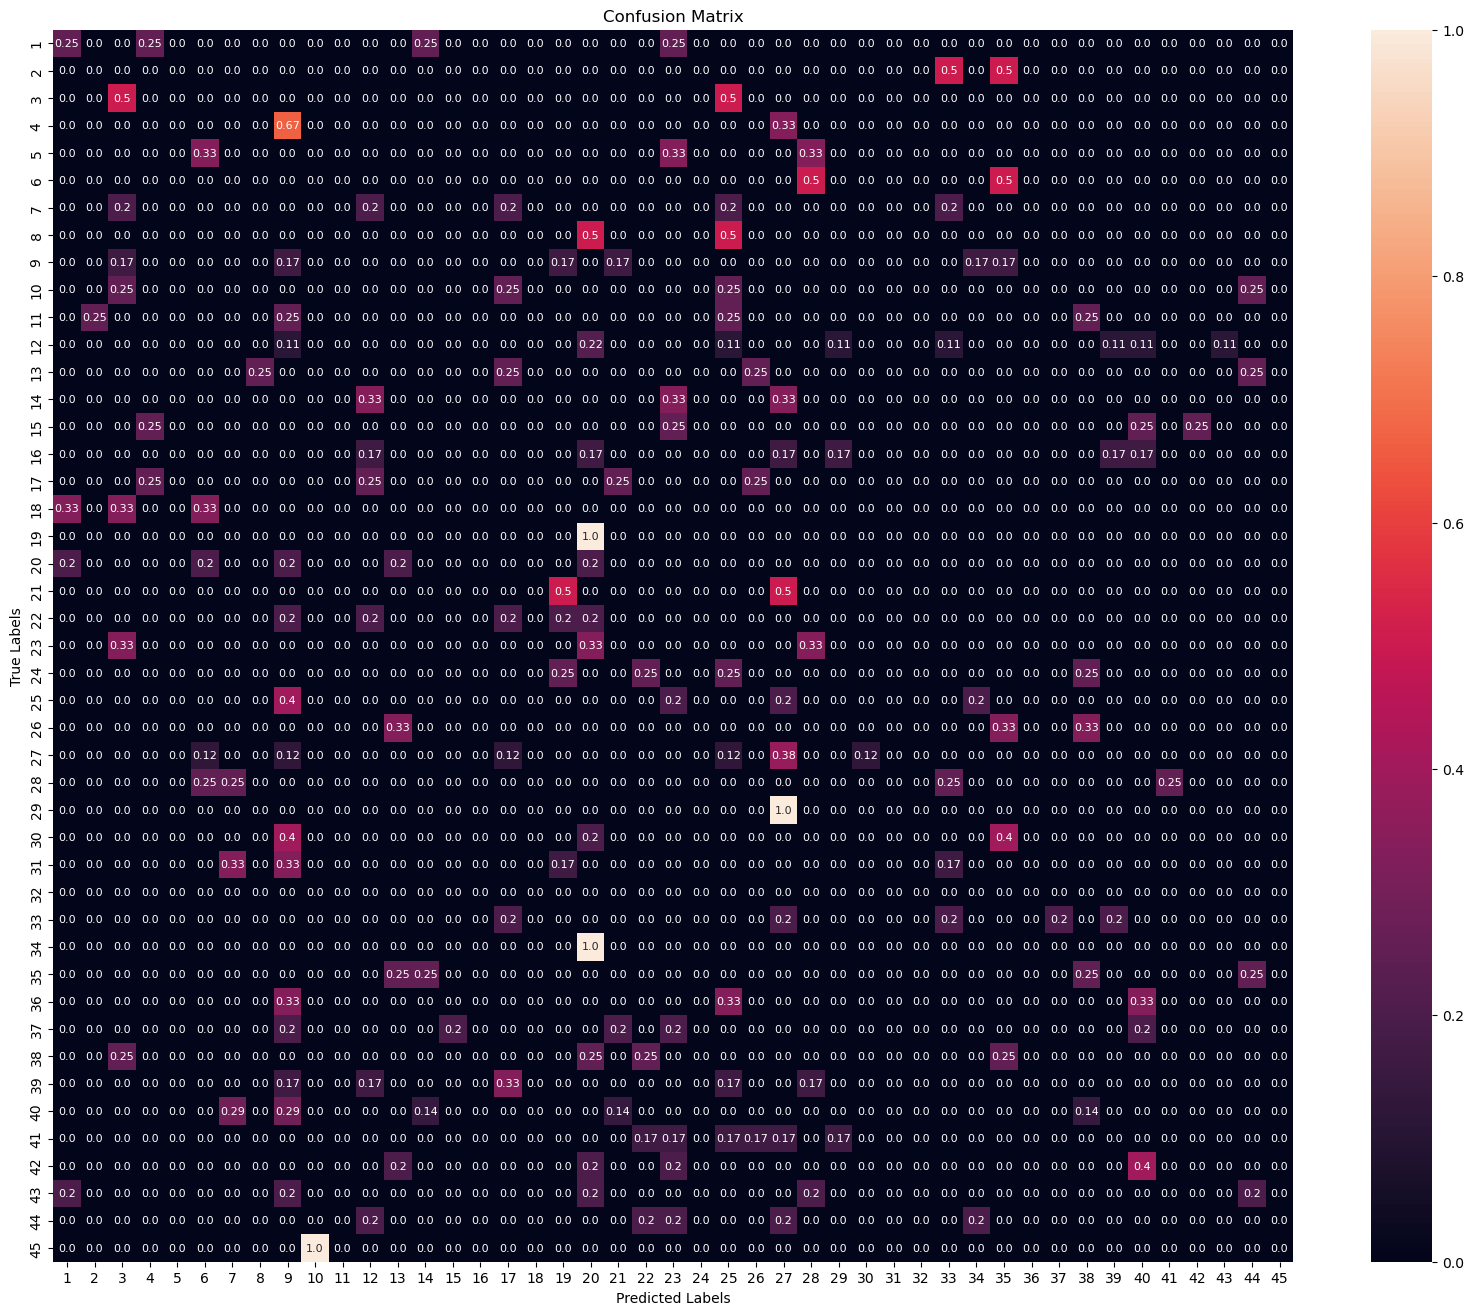

In [41]:
cm = confusion_matrix(test_labels_array, prediction_optimized, normalize='true', labels=svm_model_base.classes_)

plt.figure(figsize=(20, 16))
sns.heatmap(cm, fmt='.2', annot=True, annot_kws={"size": 8}, xticklabels=svm_model_base.classes_, yticklabels=svm_model_base.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

plt.savefig(os.path.join(NewDirectory,'Cm_optim.png'))
plt.show()



In [42]:
Acc_optimized= sum(test_labels_array == prediction_optimized)/len(test_labels_array)*100
print(Acc_optimized)

4.4692737430167595


In [43]:
file = open(os.path.join(NewDirectory,'Acc_optimized.txt'), 'w')
# Write content to the file
file.write(str(Acc_optimized))

18

In [44]:
Acc_optimized2 = balanced_accuracy_score(test_labels_array, prediction_optimized)
print(Acc_optimized2)

0.038446969696969695


In [45]:
file = open(os.path.join(NewDirectory,'Acc_optimized2.txt'), 'w')
# Write content to the file
file.write(str(Acc_optimized2))

20

In [46]:
f1 = f1_score(test_labels_array, prediction_optimized, average='weighted')

In [47]:
print(f1)

0.032238152908543975


In [48]:
file = open(os.path.join(NewDirectory,'F1.txt'), 'w')
# Write content to the file
file.write(str(f1))

20